In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision

In [3]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch import nn

from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image


In [4]:
!pip install colorlog

In [5]:
%cd /content/drive/Shareddrives/COVID-19_X-Ray/Unet/elektronn3-master/elektronn3-master

/content/drive/Shareddrives/COVID-19_X-Ray/Unet/elektronn3-master/elektronn3-master


In [6]:
from elektronn3.modules import DiceLoss

In [ ]:
#neg_root = ''

In [ ]:
# imgs = '/content/drive/Shareddrives/COVID-19_X-Ray/QaTa_Object_Detection_Dataset/QaTa-COV19/QaTa-COV19/Images'
# masks = '/content/drive/Shareddrives/COVID-19_X-Ray/QaTa_Object_Detection_Dataset/QaTa-COV19/QaTa-COV19/Ground-truths'

In [ ]:
# print(len(os.listdir(masks)))
# print(len(os.listdir(imgs)))

In [ ]:
#import shutil
# folder2 = '/content/drive/Shareddrives/COVID-19_X-Ray/QaTa_Object_Detection_Dataset/QaTa-COV19/QaTa-COV19/Images_with_annotations'

commented cells below only need to run once at the creation of this notebook

In [ ]:
#ran once to get images with annotation masks
# for name in os.listdir(masks):
#   fname = name[5:]
#   src = os.path.join(imgs, fname)

#   dest = os.path.join(folder2, fname)
#   shutil.copy(src, dest)

In [ ]:
# df = {"images" :[], "masks" :[]}

In [ ]:
# img_dir = folder2
# for name in os.listdir(img_dir):
#   df['images'].append( os.path.join(img_dir, name))
#   df["masks"].append(os.path.join(masks, "mask_" + name))
 


In [ ]:
#df = pd.DataFrame.from_dict(df)

In [ ]:
# for i in range(5):
#   print(df.loc[i, "images"])
#   print(df.loc[i, "masks"])

In [ ]:
#df.to_csv(os.path.join('/content/drive/Shareddrives/COVID-19_X-Ray/QaTa_Object_Detection_Dataset',"image_to_mask.csv"))

In [ ]:
#print(os.listdir(folder2))

In [ ]:
#print(os.listdir(masks))

end of cells that only needed to be run at the creation of this notebook

In [7]:
df = pd.read_csv('/content/drive/Shareddrives/COVID-19_X-Ray/QaTa_Object_Detection_Dataset/QaTa-COV19/QaTa-COV19/positives_only/image_to_mask_positives.csv')  #'/content/drive/Shareddrives/COVID-19_X-Ray/Unet/new_image_to_mask.csv')

In [8]:
df.head()

,Unnamed: 0,images,masks
0,0,/content/drive/Shareddrives/COVID-19_X-Ray/QaT...,/content/drive/Shareddrives/COVID-19_X-Ray/QaT...
1,1,/content/drive/Shareddrives/COVID-19_X-Ray/QaT...,/content/drive/Shareddrives/COVID-19_X-Ray/QaT...
2,2,/content/drive/Shareddrives/COVID-19_X-Ray/QaT...,/content/drive/Shareddrives/COVID-19_X-Ray/QaT...
3,3,/content/drive/Shareddrives/COVID-19_X-Ray/QaT...,/content/drive/Shareddrives/COVID-19_X-Ray/QaT...
4,4,/content/drive/Shareddrives/COVID-19_X-Ray/QaT...,/content/drive/Shareddrives/COVID-19_X-Ray/QaT...


In [ ]:
# len(df)

2951

In [9]:
from skimage.io import imread
from skimage.color import gray2rgb


class SegmentationDataSet(Dataset):
    def __init__(self,
                 inputs: list,
                 targets: list,
                 df,
                 transform=None
                 ):
        self.inputs = inputs
        self.targets = targets
        self.transform = transform
        self.inputs_dtype = torch.float32
        self.targets_dtype = torch.long

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self,
                    index: int):
        # Select the sample
        input_ID = self.inputs[index]

        target_ID = df.loc[df["images"] == input_ID, "masks"].iloc[0]

        # Load input and target
        x, y = imread(input_ID, as_gray=False), imread(target_ID)
        x = gray2rgb(x) #to give the grayscale CXR 3-channels
        #np.insert(x,1,2)
        #x =  np.expand_dims(x, axis=-1)
       # np.resize(x, (2,224,224))
        # Preprocessing
        if self.transform is not None:
            x, y = self.transform(x, y)

        # Typecasting
        x, y = torch.from_numpy(x).type(self.inputs_dtype), torch.from_numpy(y).type(self.targets_dtype)

        return x, y#, input_ID

In [ ]:
# inputs = ['/content/drive/Shareddrives/COVID-19_X-Ray/QaTa_Object_Detection_Dataset/QaTa-COV19/QaTa-COV19/Images_with_annotations/covid_1.png', '/content/drive/Shareddrives/COVID-19_X-Ray/QaTa_Object_Detection_Dataset/QaTa-COV19/QaTa-COV19/Images_with_annotations/covid_1000.png' ]
# targets = ['/content/drive/Shareddrives/COVID-19_X-Ray/QaTa_Object_Detection_Dataset/QaTa-COV19/QaTa-COV19/Ground-truths/mask_covid_1.png', '/content/drive/Shareddrives/COVID-19_X-Ray/QaTa_Object_Detection_Dataset/QaTa-COV19/QaTa-COV19/Ground-truths/mask_covid_1000.png']

# training_dataset = SegmentationDataSet(inputs=inputs,
#                                        targets=targets,
#                                        df=df,
#                                        transform=None)

# training_dataloader = DataLoader(dataset=training_dataset,
#                                       batch_size=2,
#                                       shuffle=True)
# x, y = next(iter(training_dataloader))

# print(f'x = shape: {x.shape}; type: {x.dtype}')
# print(f'x = min: {x.min()}; max: {x.max()}')
# print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')

In [ ]:
# print(x[0, :, :, 1])

# print(x[0, :, :, 0])

Transformations

In [10]:
from typing import List, Callable, Tuple

import numpy as np
import albumentations as A
from sklearn.externals._pilutil import bytescale
from skimage.util import crop
from skimage.transform import resize


def normalize_01(inp: np.ndarray):
    """Squash image input to the value range [0, 1] (no clipping)"""
    inp_out = (inp - np.min(inp)) / np.ptp(inp)
    return inp_out


def normalize(inp: np.ndarray, mean: float, std: float):
    """Normalize based on mean and standard deviation."""
    inp_out = (inp - mean) / std
    return inp_out


def create_dense_target(tar: np.ndarray):
    classes = np.unique(tar)
    dummy = np.zeros_like(tar)
    for idx, value in enumerate(classes):
        mask = np.where(tar == value)
        dummy[mask] = idx

    return dummy


def center_crop_to_size(x: np.ndarray,
                        size: Tuple,
                        copy: bool = False,
                        ) -> np.ndarray:
    """
    Center crops a given array x to the size passed in the function.
    Expects even spatial dimensions!
    """
    x_shape = np.array(x.shape)
    size = np.array(size)
    params_list = ((x_shape - size) / 2).astype(np.int).tolist()
    params_tuple = tuple([(i, i) for i in params_list])
    cropped_image = crop(x, crop_width=params_tuple, copy=copy)
    return cropped_image


def re_normalize(inp: np.ndarray,
                 low: int = 0,
                 high: int = 255
                 ):
    """Normalize the data to a certain range. Default: [0-255]"""
    inp_out = bytescale(inp, low=low, high=high)
    return inp_out


def random_flip(inp: np.ndarray, tar: np.ndarray, ndim_spatial: int):
    flip_dims = [np.random.randint(low=0, high=2) for dim in range(ndim_spatial)]

    flip_dims_inp = tuple([i + 1 for i, element in enumerate(flip_dims) if element == 1])
    flip_dims_tar = tuple([i for i, element in enumerate(flip_dims) if element == 1])

    inp_flipped = np.flip(inp, axis=flip_dims_inp)
    tar_flipped = np.flip(tar, axis=flip_dims_tar)

    return inp_flipped, tar_flipped


class Repr:
    """Evaluable string representation of an object"""

    def __repr__(self): return f'{self.__class__.__name__}: {self.__dict__}'


class FunctionWrapperSingle(Repr):
    """A function wrapper that returns a partial for input only."""

    def __init__(self, function: Callable, *args, **kwargs):
        from functools import partial
        self.function = partial(function, *args, **kwargs)

    def __call__(self, inp: np.ndarray): return self.function(inp)


class FunctionWrapperDouble(Repr):
    """A function wrapper that returns a partial for an input-target pair."""

    def __init__(self, function: Callable, input: bool = True, target: bool = False, *args, **kwargs):
        from functools import partial
        self.function = partial(function, *args, **kwargs)
        self.input = input
        self.target = target

    def __call__(self, inp: np.ndarray, tar: dict):
        if self.input: inp = self.function(inp)
        if self.target: tar = self.function(tar)
        return inp, tar


class Compose:
    """Baseclass - composes several transforms together."""

    def __init__(self, transforms: List[Callable]):
        self.transforms = transforms

    def __repr__(self): return str([transform for transform in self.transforms])


class ComposeDouble(Compose):
    """Composes transforms for input-target pairs."""

    def __call__(self, inp: np.ndarray, target: dict):
        for t in self.transforms:
            inp, target = t(inp, target)
        return inp, target


class ComposeSingle(Compose):
    """Composes transforms for input only."""

    def __call__(self, inp: np.ndarray):
        for t in self.transforms:
            inp = t(inp)
        return inp


class AlbuSeg2d(Repr):
    """
    Wrapper for albumentations' segmentation-compatible 2D augmentations.
    Wraps an augmentation so it can be used within the provided transform pipeline.
    See https://github.com/albu/albumentations for more information.
    Expected input: (C, spatial_dims)
    Expected target: (spatial_dims) -> No (C)hannel dimension
    """
    def __init__(self, albumentation: Callable):
        self.albumentation = albumentation

    def __call__(self, inp: np.ndarray, tar: np.ndarray):
        # input, target
        out_dict = self.albumentation(image=inp, mask=tar)
        input_out = out_dict['image']
        target_out = out_dict['mask']

        return input_out, target_out


Test out some Transformations

In [ ]:
# x = np.random.randint(0, 256, size=(224, 224, 3), dtype=np.uint8)
# y = np.random.randint(10, 15, size=(224, 224), dtype=np.uint8)

# transforms = ComposeDouble([
#     FunctionWrapperDouble(resize,
#                           input=True,
#                           target=False,
#                           output_shape=(64, 64, 3)),
#     FunctionWrapperDouble(resize,
#                           input=False,
#                           target=True,
#                           output_shape=(64, 64),
#                           order=0,
#                           anti_aliasing=False,
#                           preserve_range=True),
#     FunctionWrapperDouble(create_dense_target, input=False, target=True),
#     FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
#     FunctionWrapperDouble(normalize_01)
# ])

# x_t, y_t = transforms(x, y)

# print(f'x = shape: {x.shape}; type: {x.dtype}')
# print(f'x = min: {x.min()}; max: {x.max()}')
# print(f'x_t: shape: {x_t.shape}  type: {x_t.dtype}')
# print(f'x_t = min: {x_t.min()}; max: {x_t.max()}')

# print(f'y = shape: {y.shape}; class: {np.unique(y)}')
# print(f'y_t = shape: {y_t.shape}; class: {np.unique(y_t)}')

**Building a Dataset with Augmentations (Albumentations)**

In [11]:
from sklearn.model_selection import train_test_split
#import pathlib

root = '/content/drive/Shareddrives/COVID-19_X-Ray/QaTa_Object_Detection_Dataset/QaTa-COV19/QaTa-COV19/positives_only'   #'/content/drive/Shareddrives/COVID-19_X-Ray/QaTa_Object_Detection_Dataset/QaTa-COV19/QaTa-COV19'
#os.chdir(root)
def get_filenames_of_path(path):#: pathlib.Path, ext: str = '*'):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [os.path.join(path, file) for file in os.listdir(path)]#]#[file for file in path.glob(ext) if file.is_file()]
    return filenames

# input and target files
inputs = get_filenames_of_path(os.path.join(root, "Images_with_annotations")) #'Input')
targets = get_filenames_of_path(os.path.join(root, "Ground-truths") )#/ 'Target')

# training transformations and augmentations
transforms_training = ComposeDouble([
    AlbuSeg2d(A.HorizontalFlip(p=0.5)),
    AlbuSeg2d(A.augmentations.transforms.RandomBrightnessContrast(p=0.5,brightness_limit=(-0.7, 0.3), contrast_limit=0.2)),
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)
])


# validation transformations
transforms_validation = ComposeDouble([
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)
])
# transforms = ComposeDouble([
#     FunctionWrapperDouble(create_dense_target, input=False, target=True),
#     FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
#     FunctionWrapperDouble(normalize_01)
# ])

In [ ]:
# len(inputs)

2951

To test transformations

In [ ]:
# from sklearn.model_selection import train_test_split
# #import pathlib

# root = '/content/drive/Shareddrives/COVID-19_X-Ray/QaTa_Object_Detection_Dataset/QaTa-COV19/QaTa-COV19/dummy_batch'
# #os.chdir(root)
# def get_filenames_of_path(path):#: pathlib.Path, ext: str = '*'):
#     """Returns a list of files in a directory/path. Uses pathlib."""
#     filenames = [os.path.join(path, file) for file in os.listdir(path)]#]#[file for file in path.glob(ext) if file.is_file()]
#     return filenames

# # input and target files
# inputs = get_filenames_of_path(os.path.join(root, "images")) #'Input')
# targets = get_filenames_of_path(os.path.join(root, "masks") )#/ 'Target')

In [ ]:
# inputs = ['/content/drive/Shareddrives/COVID-19_X-Ray/QaTa_Object_Detection_Dataset/QaTa-COV19/QaTa-COV19/Images_with_annotations/covid_1.png']
# targets = ['/content/drive/Shareddrives/COVID-19_X-Ray/QaTa_Object_Detection_Dataset/QaTa-COV19/QaTa-COV19/Ground-truths/mask_covid_1.png']

In [ ]:
# tt = ComposeDouble([
#     AlbuSeg2d(A.HorizontalFlip(p=0.5)),
#     AlbuSeg2d(A.augmentations.transforms.RandomBrightnessContrast(p=0.5,brightness_limit=(-0.7, 0.3), contrast_limit=0.2)),
#     #AlbuSeg2d(A.augmentations.geometric.rotate.Rotate (limit=10, p=1)),
#     FunctionWrapperDouble(create_dense_target, input=False, target=True),
#     FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
#     FunctionWrapperDouble(normalize_01)
# ])

In [ ]:
#  #dataset training
# dataset_test_transforms = SegmentationDataSet(inputs=inputs,
#                                     targets=targets,
#                                     df=df,
#                                     transform=tt)

In [ ]:

# dataloader = DataLoader(dataset=dataset_test_transforms ,
#                                  batch_size=4,
#                                  shuffle=True)

In [ ]:
# view_batch(dataloader)

In [ ]:
# print(len(inputs))

5902


End of testing transformations

In [12]:
# random seed
random_seed = 42

# split dataset into training set and validation set
train_size = 0.8  # 80:20 split

inputs_train, inputs_valid = train_test_split(
    inputs,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

targets_train, targets_valid = train_test_split(
    targets,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)


In [ ]:
# print(len(inputs_valid))

591


In [ ]:
# print(len(targets_valid))

1181


In [ ]:
# print('/content/drive/Shareddrives/COVID-19_X-Ray/QaTa_Object_Detection_Dataset/QaTa-COV19/QaTa-COV19/Images_with_annotations/covid_72.png' in inputs_valid)

False


In [13]:
# dataset training
dataset_train = SegmentationDataSet(inputs=inputs_train,
                                    targets=targets_train,
                                    df=df,
                                    transform=transforms_training)

# dataset validation
dataset_valid = SegmentationDataSet(inputs=inputs_valid,
                                    targets=targets_valid,
                                    df=df,
                                    transform=transforms_validation)

In [14]:
# dataloader training
dataloader_training = DataLoader(dataset=dataset_train,
                                 batch_size=32,
                                 shuffle=True)

# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid,
                                   batch_size=32,
                                   shuffle=False)

In [ ]:
# batch = next(iter(dataloader_training))#dataset_train[0]

# x, y = batch[0]

# #print(x)
# print(f'x = shape: {x.shape}; class: {x.unique()}; type: {x.dtype}')
# print(f'x = min: {x.min()}; max: {x.max()}')
# #print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')
# print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')
# print(f'x = min: {y.min()}; max: {y.max()}')
# # i = 0
# # j = 0
# # for row in y:
# #   if not 1 in row :
# #     i+=1
# #   if 1 in row:
# #     j+=1
# # print(y.size(0), i, j)
    
# # plt.imshow(y.numpy())

**Visualize Data Loader Batch**

In [ ]:
###For loading 3-D iages with napari GUI, see code on https://towardsdatascience.com/creating-and-training-a-u-net-model-with-pytorch-for-2d-3d-semantic-segmentation-dataset-fb1f7f80fe55

In [ ]:
# def view_batch(dataloader):
#   batch = next(iter(dataloader))
#   cols = len(batch[0])
 
#   rows = 2
#   fig=plt.figure()#figsize=(512, 512))
#   axes=[]
#   i = 1
#   for img in batch [0]:

#       img = img.numpy()
#       img = re_normalize(img)
#       img = img[0]
      
#       fig.add_subplot(rows, cols, i)
#       plt.imshow(img, cmap='gray')
 
#       i+=1
#   for mask in batch[1]:

#         mask = mask.numpy()
#         mask = re_normalize(mask)
        
#         fig.add_subplot(rows, cols, i)
  
#         plt.imshow(mask, cmap='gray')
#         i+=1
#   # for id in batch[2]:
#   #     id = id.split('/')[-1]
#   #     print(id)
#   #fig.tight_layout()    
#   plt.show()

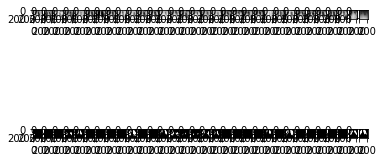

In [ ]:
# view_batch(dataloader_training)

**Build Unet**

In [ ]:
#!git clone https://github.com/ELEKTRONN/elektronn3.git

In [15]:
os.chdir('/content/drive/Shareddrives/COVID-19_X-Ray/Unet/elektronn3-master/elektronn3-master/elektronn3/models')

In [16]:
from unet import UNet as U_Net

In [17]:
model = U_Net(in_channels=3,
             out_channels=2,
             n_blocks=5,
             start_filts=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2)

In [ ]:
# x = torch.randn(size=(2, 3, 224, 224), dtype=torch.float32)
# with torch.no_grad():
#     out = model(x)

# print(f'Out: {out.shape}')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Out: torch.Size([2, 2, 224, 224])


In [ ]:
# x = torch.randn(size=(1, 1, 512, 512), dtype=torch.float32)
# with torch.no_grad():
#     out = model(x)

# print(f'Out: {out.shape}')

In [ ]:
# from torchsummary import summary
# summary = summary(model, (3, 224, 224))

In [ ]:
# shape = 224


# def compute_max_depth(shape, max_depth=10, print_out=True):
#     shapes = []
#     shapes.append(shape)
#     for level in range(1, max_depth):
#         if shape % 2 ** level == 0 and shape / 2 ** level > 1:
#             shapes.append(shape / 2 ** level)
#             if print_out:
#                 print(f'Level {level}: {shape / 2 ** level}')
#         else:
#             if print_out:
#                 print(f'Max-level: {level - 1}')
#             break

#     return shapes


# out = compute_max_depth(shape, print_out=True, max_depth=10)

Level 1: 112.0
Level 2: 56.0
Level 3: 28.0
Level 4: 14.0
Level 5: 7.0
Max-level: 5


**Training**

**NOTE: training saves model checkpoints after each epoch. If you want to save your chekcpoints in a different directory, then change to_save=**

In [18]:
to_save = '/content/drive/Shareddrives/COVID-19_X-Ray/Unet/Prof_Chan_models'  #'/content/drive/Shareddrives/COVID-19_X-Ray/Unet/models_lrschedcosine_crossentropy_batch32_lr0.1_sgd'#/content/drive/Shareddrives/COVID-19_X-Ray/Unet/models_lrschedplateau_crossentropy_batch32_lr0.4_sgd' #'/content/drive/Shareddrives/COVID-19_X-Ray/Unet/models_crossentropy_batch32_lr0.4_sgd' #'/content/drive/Shareddrives/COVID-19_X-Ray/Unet/test_run2_lr0.006' #'/content/drive/Shareddrives/COVID-19_X-Ray/Unet/Unet_models_undersampling' #'/content/drive/Shareddrives/COVID-19_X-Ray/Unet/Unet_models_dice'

In [ ]:
#!git clone https://github.com/qubvel/segmentation_models.pytorch.git

In [ ]:
#%cd /content/drive/Shareddrives/COVID-19_X-Ray/Unet/elektronn3-master/elektronn3-master


/content/drive/Shareddrives/COVID-19_X-Ray/Unet/elektronn3-master/elektronn3-master


In [ ]:
#import sys
#sys.path.append('/content/drive/Shareddrives/COVID-19_X-Ray/Unet/elektronn3-master/elektronn3-master/')

In [ ]:
#import elektronn3

In [ ]:
# import sys
# sys.path.insert(0,'/content/drive/Shareddrives/COVID-19_X-Ray/Unet/elektronn3-master/elektronn3-master')

In [ ]:
#print(os.listdir('/content/drive/Shareddrives/COVID-19_X-Ray/Unet/elektronn3-master/elektronn3-master/elektronn3'))

In [ ]:
#from elektronn3.modules import loss

In [ ]:
#from segmentation_models_pytorch.losses import dice

In [ ]:
###%pip install -q wandb

     |████████████████████████████████| 1.8 MB 7.3 MB/s 
     |████████████████████████████████| 133 kB 75.0 MB/s 
     |████████████████████████████████| 97 kB 9.6 MB/s 
     |████████████████████████████████| 170 kB 68.2 MB/s 
     |████████████████████████████████| 138 kB 79.7 MB/s 
     |████████████████████████████████| 63 kB 2.5 MB/s 
     |████████████████████████████████| 62 kB 1.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
# import wandb
# wandb.login()

# # 1. Start a new run
# wandb.init(name='models_lrschedcosine_crossentropy_batch32_lr0.1_sgd',project='Unet', entity='andy245liu')#,resume=True) #change entity to your wandb username. you need to be logged into that account



# # 2. Save model inputs and hyperparameters
# #config = wandb.config
# #config.learning_rate = 1e-3

# # 3. Log gradients and model parameters
# wandb.watch(model)

In [19]:
class Trainer:
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset = None,
                 lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook

        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []

    def run_trainer(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        progressbar = trange(self.epochs, desc='Progress')

        for i in progressbar:
            """Epoch counter"""
            self.epoch += 1  # epoch counter

            """Training block"""
            self._train()

            """Validation block"""
            if self.validation_DataLoader is not None:
                self._validate()

            """Learning rate scheduler block"""
            if self.lr_scheduler is not None:
                #if self.validation_DataLoader is not None and self.lr_scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                #    self.lr_scheduler.batch(self.validation_loss[i])  # learning rate scheduler step with validation loss
                #else:
                #    self.lr_scheduler.batch()  # learning rate scheduler step
                self.lr_scheduler.step()#self.validation_loss[-1])
            torch.save({
              'epoch': self.epoch,
              'model_state_dict': self.model.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),
              'lr_scheduler': lr_scheduler.state_dict()
              #'loss': LOSS,
              }, os.path.join(to_save,f'unet{self.epoch}.pt'))
            # wandb.log({
            #     "Epoch": self.epoch,
            #     "training loss": self.training_loss[-1],
            #     "validation loss": self.validation_loss[-1],
            #     "learning rate": self.learning_rate[-1]
            # })
        return self.training_loss, self.validation_loss, self.learning_rate

    def _train(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.train()  # train mode
        train_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', total=len(self.training_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
            self.optimizer.zero_grad()  # zerograd the parameters
            out = self.model(input)  # one forward pass
            loss = self.criterion(out, target)  # calculate loss
            loss_value = loss.item()
            train_losses.append(loss_value)
            loss.backward()  # one backward pass
            self.optimizer.step()  # update the parameters

            batch_iter.set_description(f'Training: (loss {loss_value:.4f})')  # update progressbar

        self.training_loss.append(np.mean(train_losses))
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])

        batch_iter.close()

    def _validate(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.eval()  # evaluation mode
        valid_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'Validation', total=len(self.validation_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

            with torch.no_grad():
                out = self.model(input)
                loss = self.criterion(out, target)
                loss_value = loss.item()
                valid_losses.append(loss_value)

                batch_iter.set_description(f'Validation: (loss {loss_value:.4f})')

        self.validation_loss.append(np.mean(valid_losses))

        batch_iter.close()

**Train Loop**

In [20]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
#!pip install torchgeometry

In [ ]:
#from torchgeometry.losses.dice import DiceLoss

In [21]:
model.to(device)

UNet(
  (down_convs): ModuleList(
    (0): DownConv(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (act1): ReLU()
      (act2): ReLU()
      (norm0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): DownConv(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (act1): ReLU()
      (act2): ReLU()
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1

In [ ]:
# #PyTorch
# import torch.nn.functional as F
# class DiceLoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(DiceLoss, self).__init__()

#     def forward(self, inputs, targets, smooth=1):
        
#         #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)       
#         print(inputs.shape)
#         print(targets.shape)
#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)
        
#         #intersection = (inputs * targets).sum()                            
#         #dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
#         return 1 #- dice

In [ ]:
# %cd /content/elektronn3/elektronn3/modules/

/content/elektronn3/elektronn3/modules


**NOTE: for Dice Loss, please change the criterion variable to criterion = DiceLoss() (it has been commented out)**

In [22]:


criterion = torch.nn.CrossEntropyLoss()#DiceLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)#, weight_decay = 0.0005 )#torch.optim.Adam(model.parameters(), lr=0.006, weight_decay = 0.0005)#
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)
#torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer)
print(lr_scheduler.__class__.__name__ )

CosineAnnealingWarmRestarts


In [23]:

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=dataloader_training,
                  validation_DataLoader=dataloader_validation,
                  lr_scheduler=lr_scheduler,
                  epochs=100,
                  epoch=0,
                  notebook=True)

**This next line will perform the actual training loop. If you want to use the lr finder algorithm, please skip this next cell and run the cells below under the "LR Finder" heading**

In [ ]:
####TO TRAIN MODEL jlkjjklffhjhjjkjkhkjhjkjjkljjkjkjlkjn,mnbnmbk;lk;lkjhgjhklkjlkjgjkjh,mnkljjkljkjljkhhkjhghjghjhhjkjhkjhlkj
training_losses, validation_losses, lr_rates = trainer.run_trainer()

In [ ]:
print(validation_losses) #hjkhjlkjhhjkhjjlkjlkjkl;lk;lk

In [ ]:
print(training_losses)

LR Finder

In [ ]:
from tqdm import tqdm, trange
import math


class LearningRateFinder:
    """
    Train a model using different learning rates within a range to find the optimal learning rate.
    """

    def __init__(self,
                 model: nn.Module,
                 criterion,
                 optimizer,
                 device
                 ):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.loss_history = {}
        self._model_init = model.state_dict()
        self._opt_init = optimizer.state_dict()
        self.device = device

    def fit(self,
            data_loader: torch.utils.data.DataLoader,
            steps=100,
            min_lr=1e-7,
            max_lr=1,
            constant_increment=False
            ):
        """
        Trains the model for number of steps using varied learning rate and store the statistics
        """
        self.loss_history = {}
        self.model.train()
        current_lr = min_lr
        steps_counter = 0
        epochs = math.ceil(steps / len(data_loader))

        progressbar = trange(epochs, desc='Progress')
        for epoch in progressbar:
            batch_iter = tqdm(enumerate(data_loader), 'Training', total=len(data_loader),
                              leave=False)

            for i, (x, y) in batch_iter:
                x, y = x.to(self.device), y.to(self.device)
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = current_lr
                self.optimizer.zero_grad()
                out = self.model(x)
                loss = self.criterion(out, y)
                loss.backward()
                self.optimizer.step()
                self.loss_history[current_lr] = loss.item()

                steps_counter += 1
                if steps_counter > steps:
                    break

                if constant_increment:
                    current_lr += (max_lr - min_lr) / steps
                else:
                    current_lr = current_lr * (max_lr / min_lr) ** (1 / steps)

    def plot(self,
             smoothing=True,
             clipping=True,
             smoothing_factor=0.1
             ):
        """
        Shows loss vs learning rate(log scale) in a matplotlib plot
        """
        loss_data = pd.Series(list(self.loss_history.values()))
        lr_list = list(self.loss_history.keys())
        if smoothing:
            loss_data = loss_data.ewm(alpha=smoothing_factor).mean()
            loss_data = loss_data.divide(pd.Series(
                [1 - (1.0 - smoothing_factor) ** i for i in range(1, loss_data.shape[0] + 1)]))  # bias correction
        if clipping:
            loss_data = loss_data[10:-5]
            lr_list = lr_list[10:-5]
        plt.plot(lr_list, loss_data)
        plt.xscale('log')
        plt.title('Loss vs Learning rate')
        plt.xlabel('Learning rate (log scale)')
        plt.ylabel('Loss (exponential moving average)')
        plt.show()

    def reset(self):
        """
        Resets the model and optimizer to its initial state
        """
        self.model.load_state_dict(self._model_init)
        self.optimizer.load_state_dict(self._opt_init)
        print('Model and optimizer in initial state.')

Progress: 100%|██████████| 14/14 [33:51<00:00, 145.13s/it]


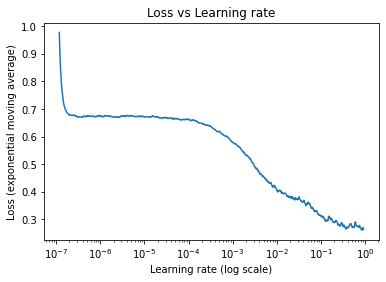

In [ ]:
lrf = LearningRateFinder(model, criterion, optimizer, device)
lrf.fit(dataloader_training, steps=100) #CAN CHANGE steps= TO 1000 too, but it will take more time. 
lrf.plot()

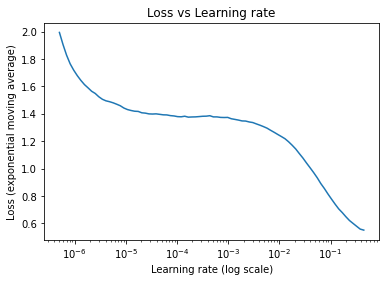

In [ ]:
#lrf.plot()#jkljkjkkhkjhl;fdfkljfdf


Making predictions **You may skip the rest of this notebook if you only care about training process**

In [ ]:
#checkpoint = torch.load('/content/drive/Shareddrives/COVID-19_X-Ray/Unet/Unet_models_dice/unet18.pt')  #'/content/drive/Shareddrives/COVID-19_X-Ray/Unet/Unet_models_optim_lr0.3/unet80.pt')#, map_location="cpu")

In [ ]:
#model.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [ ]:
ckpt2 = torch.load('/content/drive/Shareddrives/COVID-19_X-Ray/Unet/Unet_models_undersampling/unet43.pt') #, map_location = 'cpu' )#'/content/drive/Shareddrives/COVID-19_X-Ray/Unet/Unet_models_dice/unet18.pt')  #'/content/drive/Shareddrives/COVID-19_X-Ray/Unet/Unet_models_optim_lr0.3/unet16.pt')#, map_location="cpu")
model.load_state_dict(ckpt2['model_state_dict'])

<All keys matched successfully>

In [ ]:
def predict(img,
            model,
            preprocess,
            postprocess,
            device,
            ):
    model.eval()
    img = preprocess(img)  # preprocess image
    x = torch.from_numpy(img).to(device)  # to torch, send to device
    with torch.no_grad():
        out = model(x)  # send through model/network

    out_softmax = torch.softmax(out, dim=1)  # perform softmax on outputs
    result = postprocess(out_softmax)  # postprocess outputs

    return result

In [ ]:
# preprocess function
def preprocess(img: np.ndarray):
    img = np.moveaxis(img, -1, 0)  # from [H, W, C] to [C, H, W]
    img = normalize_01(img)  # linear scaling to range [0-1]
    img = np.expand_dims(img, axis=0)  # add batch dimension [B, C, H, W]
    img = img.astype(np.float32)  # typecasting to float32
    return img


# postprocess function
def postprocess(img: torch.tensor):
    img = torch.argmax(img, dim=1)  # perform argmax to generate 1 channel
    img = img.cpu().numpy()  # send to cpu and transform to numpy.ndarray
    img = np.squeeze(img)  # remove batch dim and channel dim -> [H, W]
    img = re_normalize(img)  # scale it to the range [0-255]
    return img

# predict the segmentation maps 

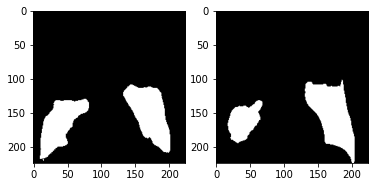

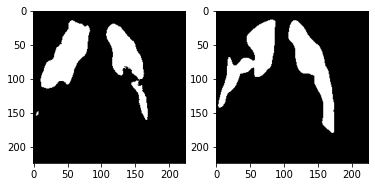

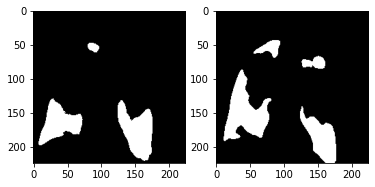

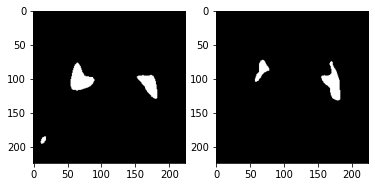

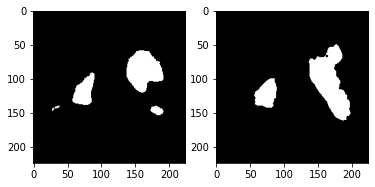

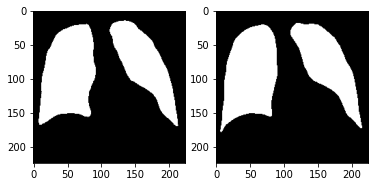

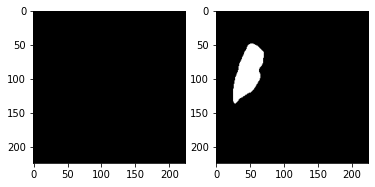

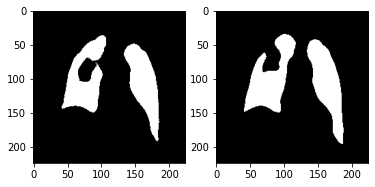

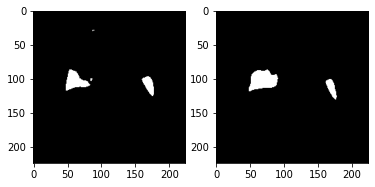

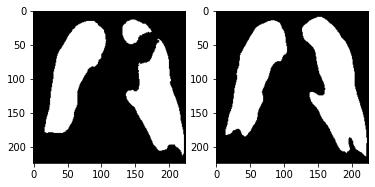

In [ ]:
i = 0
for img in inputs_valid:
  if i == 10:
    break
  mask = img.split('/')[-1]
  mask = "mask_" + mask
  #/content/drive/Shareddrives/COVID-19_X-Ray/QaTa_Object_Detection_Dataset/QaTa-COV19/QaTa-COV19/Ground-truths
  mask = os.path.join('/content/drive/Shareddrives/COVID-19_X-Ray/QaTa_Object_Detection_Dataset/QaTa-COV19/QaTa-COV19/positives_only/Ground-truths', mask)
  x, y = imread(img, as_gray=False), imread(mask)
  x = gray2rgb(x)
  output = predict(x, model, preprocess, postprocess, device)
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(output, cmap='gray')
  axarr[1].imshow(y, cmap='gray')
  #plt.imshow(output, cmap='gray')

  plt.show()
  i+= 1

In [ ]:
for i in range(20):
  img = df.loc[i, "images"]
  mask = df.loc[i, "masks"]
  x, y = imread(img, as_gray=False), imread(mask)
  
  x = gray2rgb(x)
  output = predict(x, model, preprocess, postprocess, device)
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(output, cmap='gray')
  axarr[1].imshow(y, cmap='gray')
  #plt.imshow(output, cmap='gray')
  plt.show()
# print(img)
# print(mask)

In [ ]:
img = df.loc[1, "images"]
mask = df.loc[1, "masks"]
x, y = imread(img, as_gray=False), imread(mask)
x = gray2rgb(x)

output = predict(x, model, preprocess, postprocess, device)

In [ ]:
i = 0
j = 0
k=0
for row in output:
  for elem in row:
    if elem != 0:
      print('found')
      k+=1
#print(output.shape, i, j)

In [ ]:
print(k)

In [ ]:
print(output)

In [ ]:
type(output)

In [ ]:
plt.imshow(y, cmap='gray')
plt.show()